<a href="https://colab.research.google.com/github/ChristopherLiew/Classifying-Red-Wine-Quality/blob/master/Gradient_Boosted_Trees_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> The Gradient Boosted Trees Classifier </h1>
<h3> Strengths of the Gradient Boosted Trees: </h3>

1.   Uses many shallow trees, i.e. 8-32 leaf nodes at max. , thus it circumvents high variance as compared to random forests or decision trees.
2.   Grows sequentially, and thus iteratively corrects the errors of previous trees. Thus possibly more accurate than other ensemble methods like Random Forests.


<h3> Weaknesses of the Gradient Boosted Trees: </h3>

1.   Take longer to train due to sequential building of trees.




In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot') # optional: for ggplot-like style
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
!pip install eli5
import eli5

     |████████████████████████████████| 112kB 2.7MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
wine_df = pd.read_csv("/content/gdrive/My Drive/Business Analytics Stuff/BT2101 Group Project/winequality-red.csv")

<h2>Wrangled & Processed Red Wine Quality Dataset</h2>
<p> The gradient boosting algorithm which is predicated upon gradient descent, is sensitive to the magnitude of our values. Thus, it would benefit from feature scaling to expedite our gradient boosting algorithm. </p>
<p></p>
<p>Additionally, since Tree-based methods utilise entropy and information gain to essentially engage in 'automatic' feature selection, feature selection will not be used. Instead, we will compute the feature importance and iteratively remove any features which have an insignificant amount of feature importance.</p>

In [39]:
# Creating the Binary Target Variable
wine_df["good_quality"] = wine_df["quality"] >= 7

# Target Variable
target = wine_df.loc[:, 'good_quality']
target = target.astype(int)  # 1 = good quality & 0 = other quality
target

# Interaction Terms
wine_df['total_acidity'] = wine_df['fixed acidity'] + wine_df['volatile acidity']
wine_df['pH_sulphate'] = wine_df['pH'] * wine_df['sulphates']

wine_df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good_quality,pH_sulphate,total_acidity
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False,1.9656,8.10
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,False,2.1760,8.68
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,False,2.1190,8.56
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,False,1.8328,11.48
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False,1.9656,8.10


<h2>Train-Test Data</h2>
<p> Train: 75% & Test: 25%</p>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(wine_df.drop(columns=['quality', 'good_quality']), target, test_size=0.25,random_state=0)

<h2>Feature Scaling & Normalisation</h2>

In [41]:
# Feature Scaling (For Gradient Descent Efficiency) 
robust = RobustScaler(quantile_range=(0.25, 0.75))  
X_train_sc = pd.DataFrame(robust.fit_transform(X_train), columns=X_train.columns)

X_test_sc = pd.DataFrame(robust.fit_transform(X_test), columns=X_test.columns)

# Standardisation
col_names = X_train.columns
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_sc)
X_train_sc = pd.DataFrame(X_train_sc, columns=col_names)

X_test_sc = scaler.fit_transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=col_names)

X_train_sc.head(5)
X_test_sc.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pH_sulphate,total_acidity
0,1.445794,-0.304042,0.814401,-0.322967,1.895162,1.197176,0.762305,0.779197,-0.957272,0.714156,0.306234,0.502211,1.438163
1,-0.093801,1.818945,-1.385300,1.369621,0.155956,-1.016556,-1.019862,0.957542,0.273113,-0.870178,-0.821441,-0.841156,0.078335
2,0.476419,-1.395864,0.302843,-0.365282,-0.576341,-0.211562,-0.574320,-0.815417,-0.374458,1.265228,1.151990,1.205961,0.350301
3,1.103662,0.757452,0.456310,-0.576855,-0.805183,-1.016556,-1.019862,0.779197,-0.957272,-1.627903,-0.445549,-1.801864,1.192237
4,2.244103,-0.425356,1.121336,-0.915373,-0.301729,-1.217804,-1.294042,0.097290,-1.216301,-0.181337,-0.069657,-0.432630,2.236701


<h2>Hyperparameter Tuning with RandomisedSearchCV</h2>

In [42]:
# Random Forest Classifier
GB_classifier = GradientBoostingClassifier()

# Hyperparameter Tuning with RandomSearchCV only since GridSearchCV on an iterative algo would be too time expensive
rnd_param = {
    'n_estimators': [100, 300, 500, 800, 1000, 1200, 1400],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_leaf_nodes': [8,16,24,32],
    'max_depth': [10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100],
}

rnd_sr = RandomizedSearchCV(estimator=GB_classifier,
                            param_distributions=rnd_param,
                            scoring="f1_macro",
                            n_iter=100,
                            cv=5,
                            n_jobs=-1)

rnd_sr.fit(X_train_sc, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [43]:
print("Best Parameters: ", rnd_sr.best_params_)
print("Best Score: {:,.3f}".format(rnd_sr.best_score_)) # GB Trees are skewing towards overfitting already

Best Parameters:  {'n_estimators': 1000, 'max_leaf_nodes': 32, 'max_depth': 50, 'learning_rate': 0.5}
Best Score: 0.770


<h2>Training the Gradient Boosted Classifier</h2>
<p>Max. leaf nodes set to 32 (given by GridSearchCV), to ensure 'shallowness' of trees and hence lower variance</p>

In [0]:
GB_classifier = GradientBoostingClassifier(random_state=0, learning_rate=0.5, max_depth=50, max_leaf_nodes=32, n_estimators=1000) # Based on GridSearchCV hyperparameter tuning
GB_classifier.fit(X_train_sc, y_train)

#Predicting the Test results
y_pred = GB_classifier.predict(X_test_sc)

<h2>Evaluating the Gradient Boosted Trees</h2>

<h3>Classification Report</h3>

In [46]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.953890,0.932394,0.943020,355.0
1,0.547170,0.644444,0.591837,45.0
accuracy,0.900000,0.900000,0.900000,0.9
macro avg,0.750530,0.788419,0.767428,400.0
weighted avg,0.908134,0.900000,0.903512,400.0


<h3>ROC & AUC</h3>

Gradient Boosted Trees: ROC AUC=0.917
No Model: ROC AUC=0.500


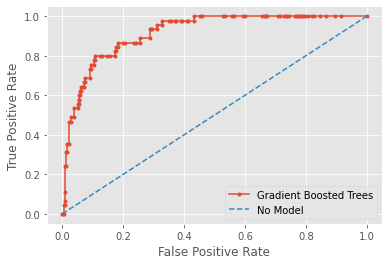

In [47]:
# prediction probabilities
gb_probs = GB_classifier.predict_proba(X_test_sc)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
gb_probs = gb_probs[:, 1]
# calculate scores
gb_auc = roc_auc_score(y_test, gb_probs)
ns_auc = roc_auc_score(y_test, ns_probs)
# summarize scores
print('Gradient Boosted Trees: ROC AUC=%.3f' % (gb_auc))
print('No Model: ROC AUC=%.3f' % (ns_auc))
# calculate ROC curves
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plot the ROC curve for the Gradient Boosted Classifier
plt.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boosted Trees')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

<h3>Precision Recall Curve</h3>

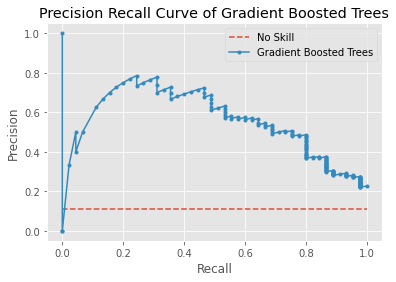

In [48]:
gb_probs = GB_classifier.predict_proba(X_test_sc)
gb_probs = gb_probs[:, 1] # Keep probability predictions for good quality (=1) class only
precisions, recalls, _ = precision_recall_curve(y_test, gb_probs)

# Plot PR-Curve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recalls, precisions, marker='.', label='Gradient Boosted Trees')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# annotate optimised model's recall and precision
# Title
plt.title("Precision Recall Curve of Gradient Boosted Trees")
# show the plot
plt.show()

<h2>Feature Importance (Testing our Hypotheses)</h2>
<p> https://stackoverflow.com/questions/49170296/scikit-learn-feature-importance-calculation-in-decision-trees </p>
<p> https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3</p>
<p>Feature Importance is measured by GINI importance which is in turn calculated by the Mean Decrease in Impurity = the sum over the number of splits (across all tress) that include the feature, proportionally to the number of samples it splits.</p>

In [49]:
for name, importance in zip(X_test_sc.columns, GB_classifier.feature_importances_):
...     print(name, "=", importance)

fixed acidity = 0.01244158224489539
volatile acidity = 0.12339754504461788
citric acid = 0.061193080101442074
residual sugar = 0.08562858518497529
chlorides = 0.05617115618453518
free sulfur dioxide = 0.07149574519786421
total sulfur dioxide = 0.04151083683852671
density = 0.03435460370764705
pH = 0.07383648143725491
sulphates = 0.10217841163448924
alcohol = 0.23090277268260884
pH_sulphate = 0.04076285604640819
total_acidity = 0.066126343694735


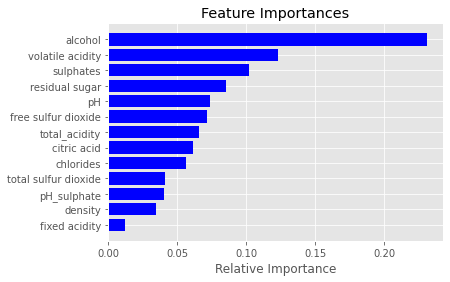

In [50]:
features = X_test_sc.columns
importances = GB_classifier.feature_importances_
indices = np.argsort(importances)

#Graphing it
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<h2>Permutation Importance</h2>

In [51]:
# Permutation Importance (eli5)
import eli5
from eli5.sklearn import PermutationImportance
GB_classifier = GradientBoostingClassifier(random_state=0, learning_rate=0.1, max_depth=90, max_leaf_nodes=32, n_estimators=1400)
GB_classifier.fit(X_train_sc, y_train)
perm = PermutationImportance(GB_classifier, random_state=1, scoring="f1_macro", n_iter=10).fit(X_test_sc, y_test)
eli5.show_weights(perm, feature_names = X_test_sc.columns.tolist()) # See on Jupyter Notebook


Weight,Feature
0.1397 ± 0.0611,alcohol
0.0707 ± 0.0553,volatile acidity
0.0522 ± 0.0359,total sulfur dioxide
0.0497 ± 0.0350,sulphates
0.0287 ± 0.0240,chlorides
0.0139 ± 0.0263,density
0.0110 ± 0.0338,citric acid
0.0080 ± 0.0287,residual sugar
0.0068 ± 0.0258,pH_sulphate
0.0064 ± 0.0206,pH


In [53]:
# Results from Perm Importance ELI5 Feature Selection
X_train_eli5 = X_train_sc.copy()
X_train_eli5 = X_train_eli5.drop(columns = ['fixed acidity'])
GB_classifier_eli5 = GradientBoostingClassifier(random_state=0, learning_rate=0.5, max_depth=50, max_leaf_nodes=32, n_estimators=1000) 
GB_classifier_eli5.fit(X_train_eli5, y_train)
y_pred = GB_classifier_eli5.predict(X_test_sc.drop(columns = ['fixed acidity']))
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.946023,0.938028,0.942008,355.0000
1,0.541667,0.577778,0.559140,45.0000
accuracy,0.897500,0.897500,0.897500,0.8975
macro avg,0.743845,0.757903,0.750574,400.0000
weighted avg,0.900533,0.897500,0.898936,400.0000


<p>No improvement in key evaluation metrics: Good Quality f1-score and Macro Averaged f1-score</p>